In [ ]:
!pip install transformers


In [ ]:
#install hugging face evaluate 
!pip install evaluate

In [3]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import pipeline

#from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
from textwrap import wrap


import evaluate


from sklearn.metrics import confusion_matrix, classification_report  


In [4]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [5]:
# Read Data

# English Trainset
eng_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/train_seg.csv") 

# English Validationset
eng_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_csv/val_seg.csv") 

# German Testset 
ger_testset=pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /ger_testset.csv")

In [6]:
#one-hot encoding the labels 
def to_sentiment(label):
  if label == True:
    return 1
  elif label == False:
    return 0

ger_testset['label'] = ger_testset['label'].apply(to_sentiment)

In [7]:
#from transformers import AutoTokenizer, AutoModelForMaskedLM
#from transformers import AutoTokenizer, AutoModelForSequenceClassification


#tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )
model= AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base")

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
#model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base", num_labels=2)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [8]:
#data to list
X_train = list(eng_trainset["segment"])
y_train = list(eng_trainset["label"])
X_val = list(eng_valset["segment"])
y_val = list(eng_valset["label"])
X_test = list(ger_testset["messages_de"])
y_test = list(ger_testset["label"])
     

In [9]:
#tokenize 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

In [10]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
     

In [11]:
#load the 3 dataset
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)
test_dataset = Dataset(test_encodings, y_test)

In [12]:
# Define Trainer
args = TrainingArguments(
    output_dir="xmlRob_EnGr",
    num_train_epochs=4,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset)

In [13]:
#train
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.335200
1000,0.377900


TrainOutput(global_step=1156, training_loss=0.35726856772874876, metrics={'train_runtime': 1744.5496, 'train_samples_per_second': 10.572, 'train_steps_per_second': 0.663, 'total_flos': 4852820305059840.0, 'train_loss': 0.35726856772874876, 'epoch': 4.0})

In [ ]:
notebook_login()


In [ ]:

#push model to hub
trainer.push_to_hub()

# **Test XML-Roberta on German Data**

In [14]:

#get prediction from test data 
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
     

In [15]:

# macro f1 on test data 
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=y_test,  average="macro")
     

{'f1': 0.47489038092628116}

In [16]:
class_names = [ 'non predator', 'predator']
     

In [17]:
#classification report

print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

non predator       0.90      1.00      0.95     13863
    predator       0.00      0.00      0.00      1466

    accuracy                           0.90     15329
   macro avg       0.45      0.50      0.47     15329
weighted avg       0.82      0.90      0.86     15329



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


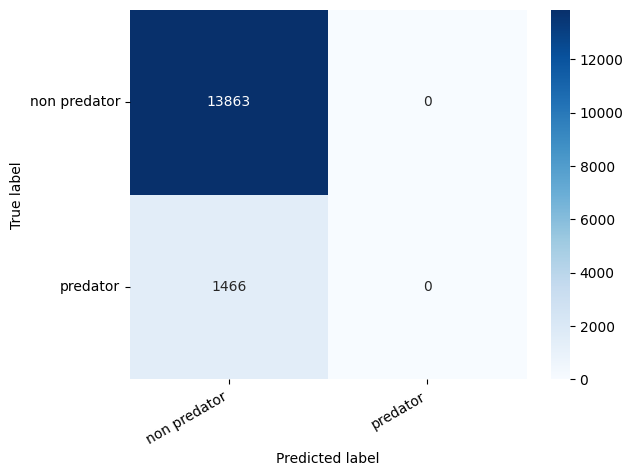

In [18]:

#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
     

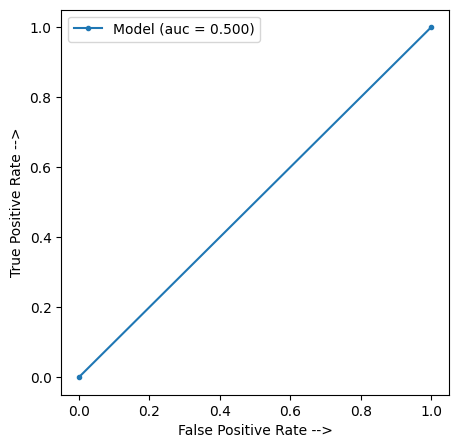

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, preds)
auc = auc(fpr, tpr)

#svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
#auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5, 5), dpi=100)
#plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(fpr, tpr, marker='.', label='Model (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()